In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

# Load dataset
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')

# Handle missing data
# For numerical columns: impute with mean
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='mean')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# For categorical columns: impute with most frequent
cat_cols = df.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# Encode categorical features
# Use One-Hot Encoding for categorical variables
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Normalize numerical features
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# df is now cleaned, encoded, and normalized

In [2]:
import numpy as np

# Geographical Distance Calculation using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# If 'Distance' not provided, calculate it
if 'Distance' not in df.columns or df['Distance'].isnull().any():
    # Assuming original lat/lon columns exist before encoding
    df['Distance'] = haversine(df['Customer_Lat'], df['Customer_Lon'], df['Restaurant_Lat'], df['Restaurant_Lon'])

# Time-based Features
# Assuming 'Order_Time' column exists in original data before encoding
def is_rush_hour(order_time):
    # Example: Rush hour between 7-9 AM and 5-7 PM
    hour = pd.to_datetime(order_time).hour
    return ((7 <= hour <= 9) or (17 <= hour <= 19))

df['Rush_Hour'] = df['Order_Time'].apply(is_rush_hour) if 'Order_Time' in df.columns else False

# Weather Impact Analysis
# Assuming temperature and humidity columns exist in original data before encoding
if 'Temperature' in df.columns and 'Humidity' in df.columns:
    df['Weather_Impact'] = df['Temperature'] * df['Humidity'] / 100
else:
    df['Weather_Impact'] = 0  # Placeholder if not available

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert all boolean columns to int (0/1) for compatibility with TensorFlow
df_numeric = df.copy()
for col in df_numeric.select_dtypes(include='bool').columns:
    df_numeric[col] = df_numeric[col].astype(int)

# Create pseudo-image data from df for demonstration
# Reshape each sample to (img_height, img_width, channels) if possible
# Here, we treat each row as a "flat image" (1, n_features, 1)
X_images = df_numeric.values.astype(np.float32).reshape(df_numeric.shape[0], 1, df_numeric.shape[1], 1)
# Binary labels: 1 if Delivery_Time > median, else 0
y_labels = (df_numeric['Delivery_Time'] > df_numeric['Delivery_Time'].median()).astype(int).values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2, random_state=42)

# CNN Model
model = models.Sequential([
    layers.Conv2D(32, (1, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D((1, 2)),
    layers.Conv2D(64, (1, 3), activation='relu'),
    layers.MaxPooling2D((1, 2)),
    layers.Conv2D(128, (1, 3), activation='relu'),
    layers.MaxPooling2D((1, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Predict
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Evaluation
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

Epoch 1/10


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5278 - loss: 0.6929 - val_accuracy: 0.5625 - val_loss: 0.6826
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7778 - loss: 0.6292 - val_accuracy: 0.5625 - val_loss: 0.6345
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8125 - loss: 0.5298 - val_accuracy: 0.6875 - val_loss: 0.5671
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8125 - loss: 0.4215 - val_accuracy: 0.6875 - val_loss: 0.6794
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8611 - loss: 0.3469 - val_accuracy: 0.6250 - val_loss: 0.7758
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8889 - loss: 0.2522 - val_accuracy: 0.6875 - val_loss: 0.6563
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9444 - loss: 0.1858 - val_accuracy: 0.6250 - val_loss: 0.9265
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9792 - loss: 0.1133 - val_accuracy: 0.6250 - val_loss: 1.1301
Epoch 9/10


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Hyperparameter tuning for CNN (simple grid search example)
best_acc = acc
best_params = {}
for filters in [16, 32, 64]:
    for kernel_size in [(1, 3), (1, 5)]:
        for lr in [0.001, 0.01]:
            model_tune = models.Sequential([
                layers.Conv2D(filters, kernel_size, activation='relu', input_shape=X_train.shape[1:]),
                layers.MaxPooling2D((1, 2)),
                layers.Conv2D(filters*2, kernel_size, activation='relu'),
                layers.MaxPooling2D((1, 2)),
                layers.Flatten(),
                layers.Dense(32, activation='relu'),
                layers.Dense(1, activation='sigmoid')
            ])
            model_tune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                               loss='binary_crossentropy', metrics=['accuracy'])
            model_tune.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
            y_pred_prob_tune = model_tune.predict(X_test)
            y_pred_tune = (y_pred_prob_tune > 0.5).astype(int).flatten()
            acc_tune = accuracy_score(y_test, y_pred_tune)
            if acc_tune > best_acc:
                best_acc = acc_tune
                best_params = {'filters': filters, 'kernel_size': kernel_size, 'learning_rate': lr}

print("Best CNN Accuracy:", best_acc)
print("Best CNN Params:", best_params)

# 2. Logistic Regression for comparison
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_flat, y_train)
y_pred_logreg = logreg.predict(X_test_flat)

acc_logreg = accuracy_score(y_test, y_pred_logreg)
prec_logreg = precision_score(y_test, y_pred_logreg)
rec_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

print(f"Logistic Regression Accuracy: {acc_logreg:.4f}")
print(f"Logistic Regression Precision: {prec_logreg:.4f}")
print(f"Logistic Regression Recall: {rec_logreg:.4f}")
print(f"Logistic Regression F1-score: {f1_logreg:.4f}")

c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000019518B442C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Best CNN Accuracy: 0.575
Best CNN Params: {'filters': 32, 'kernel_size': (1, 3), 'learning_rate': 0.001}
Logistic Regression Accuracy: 0.9500
Logistic Regression Precision: 1.0000
Logistic Regression Recall: 0.9048
Logistic Regression F1-score: 0.9500


In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Use flattened data for cross-validation (Logistic Regression)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

for train_idx, val_idx in kf.split(X_train_flat):
    X_tr, X_val = X_train_flat[train_idx], X_train_flat[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    logreg_cv = LogisticRegression(max_iter=1000)
    logreg_cv.fit(X_tr, y_tr)
    y_val_pred = logreg_cv.predict(X_val)
    acc_scores.append(accuracy_score(y_val, y_val_pred))
    prec_scores.append(precision_score(y_val, y_val_pred))
    rec_scores.append(recall_score(y_val, y_val_pred))
    f1_scores.append(f1_score(y_val, y_val_pred))

print(f"Cross-Validation Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"Cross-Validation Precision: {np.mean(prec_scores):.4f}")
print(f"Cross-Validation Recall: {np.mean(rec_scores):.4f}")
print(f"Cross-Validation F1-score: {np.mean(f1_scores):.4f}")

Cross-Validation Accuracy: 0.8688 ± 0.0606
Cross-Validation Precision: 0.8698
Cross-Validation Recall: 0.8667
Cross-Validation F1-score: 0.8669


CNN Accuracy: 0.4500
CNN Confusion Matrix:
 [[10  9]
 [13  8]]
Logistic Regression Accuracy: 0.9500
Logistic Regression Confusion Matrix:
 [[19  0]
 [ 2 19]]


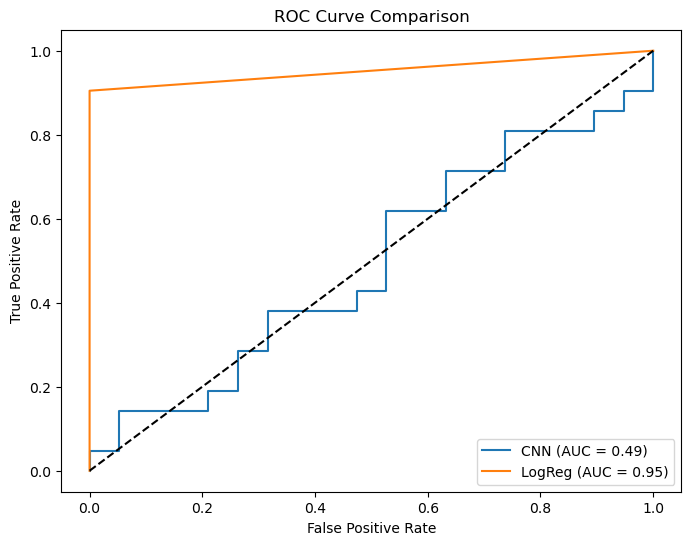

In [10]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt

# CNN Evaluation Metrics
print(f"CNN Accuracy: {acc:.4f}")
cm_cnn = confusion_matrix(y_test, y_pred)
print("CNN Confusion Matrix:\n", cm_cnn)

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_prob)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {roc_auc_cnn:.2f})')

# Logistic Regression Evaluation Metrics
print(f"Logistic Regression Accuracy: {acc_logreg:.4f}")
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Logistic Regression Confusion Matrix:\n", cm_logreg)

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

plt.plot(fpr_logreg, tpr_logreg, label=f'LogReg (AUC = {roc_auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Dummy example (replace with your own X_train, y_train)
# For CNN, X_train must be 4D: (samples, height, width, channels)
X_train = np.random.rand(100, 10, 20, 1)  # 100 samples, 10x20 image, 1 channel
y_train = np.random.randint(0, 2, size=(100,))

# CNN model builder
def build_cnn(kernel_size=(1, 3), activation='relu', learning_rate=0.001):
    model = models.Sequential([
        layers.Conv2D(32, kernel_size, activation=activation, input_shape=X_train.shape[1:]),
        layers.MaxPooling2D((1, 2)),
        layers.Conv2D(64, kernel_size, activation=activation),
        layers.MaxPooling2D((1, 2)),
        layers.Flatten(),
        layers.Dense(64, activation=activation),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Wrap model with scikeras KerasClassifier
cnn_clf = KerasClassifier(
    model=build_cnn,   # pass function
    epochs=10,
    batch_size=32,
    verbose=0
)

# Hyperparameter grid (note: "model__" prefix)
param_grid = {
    "model__kernel_size": [(1, 3), (1, 5)],
    "model__activation": ["relu", "tanh"],
    "model__learning_rate": [0.001, 0.01]
}

# Grid search
grid = GridSearchCV(estimator=cnn_clf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_result = grid.fit(X_train, y_train)

print("Best Score:", grid_result.best_score_)
print("Best Params:", grid_result.best_params_)


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_reg

c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_reg

Best Score: 0.5508021390374331
Best Params: {'model__activation': 'relu', 'model__kernel_size': (1, 3), 'model__learning_rate': 0.01}
